Code to calculate the total referrals for the pre- and post-implementation periods for services using the AI-enabled tool, match the services to most similar other services not using the tool and plot Figure 2 and perform the statistical tests

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import math
from scipy.stats import chi2_contingency 
import datetime
from dateutil.relativedelta import relativedelta as relativedelta
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import io
import sys
import scipy
from numpy.linalg import norm

data_folder="./Annual_data/"

folder_figures_save='/Users/johanna/Library/CloudStorage/GoogleDrive-johanna@limbic.ai/Shared drives/05_Research/Publications (research papers)/Clinical/Increased_Access/Figures/'


## Combine and clean data

In [2]:
data_new=pd.read_csv(data_folder+'NHS_England_Feb-2022.csv', na_values = '*') #data from Feb 2021 to Feb 2022
data_old=pd.read_csv(data_folder+'NHS_England_Feb-2021.csv', na_values = '*') #data from Feb 2020 to Feb 2021
data_2 = pd.read_csv(data_folder +'iapt_time_series_aug_21_aug_22_key_measures.csv', na_values = '*') #data from Auguts 2021 to August 2022

data_all=pd.concat([data_new, data_old])
data_all=pd.concat([data_all, data_2])
data_all.drop_duplicates(inplace=True)

In [3]:
# change 'surrey iapt' to "mind matters surrey nhs" as their name was changed from March 2022
data_all.loc[data_all["ORG_NAME2"] == 'SURREY IAPT', 'ORG_NAME2'] = 'MIND MATTERS SURREY NHS'

In [4]:
#exclude services without webform

excluded = ['1POINT (NORTH WEST)', 'ISLE OF WIGHT NHS TRUST', 'THE BRIARY UNIT', 
 'TAMESIDE, OLDHAM AND GLOSSOP MIND', 'BLACKBURN CENTRE', 'SIX DEGREES SOCIAL ENTERPRISE CIC',
 'LIFT PSYCHOLOGY SWINDON', 'WEST ESSEX IAPT', 'THE NEWCASTLE UPON TYNE HOSPITALS NHS FOUNDATION TRUST',
 'BOOTHAM PARK HOSPITAL - ADMIN', 'FIELDHEAD HOSPITAL']


data_all = data_all[~data_all['ORG_NAME2'].isin(excluded)]


## Caclulate total referral for services using the AI-enabled self-referral tool

In [5]:
# Define functions

#Function to calculate the total referrals and also the monthly referrals
def get_referral_sum(data_provider, dates_previous):  

    referrals=[]
    referrals_timeline=[]
    services_total = []
    services_names =[]

    for s in data_provider['ORG_NAME2'].unique(): #all services within one provider
        data_service=data_provider[data_provider['ORG_NAME2']==s]
        r=[]
        for d in dates_previous:  #dates for previous months
            data_months=data_service[data_service['REPORTING_PERIOD_START']==d]
            try: 
                arr=np.array(data_months['MEASURE_VALUE'][data_months['MEASURE_NAME']=='Count_ReferralsReceived']) #Count_SelfReferrals  Count_ReferralsReceived
                ref_months=int(arr[0])
                referrals.append(ref_months) 
                r.append(ref_months)
            except: 
                referrals.append(np.nan) 
                r.append(np.nan) 
        referrals_timeline.append(r) #referrals per month 
        services_total.append(sum(r)) #total referrals
        services_names.append(s) #name of service

    return services_names, services_total, referrals_timeline

#calculate the total and monthly referrals for pre and post perioud
def get_referral_rates(dates_previous, dates_after, data): 
    service, referrals_total_before, timeline_referrals_before = get_referral_sum(data, dates_previous)
    service, referrals_total_after, timeline_referrals_after = get_referral_sum(data, dates_after)

    return service, referrals_total_before, referrals_total_after, timeline_referrals_before, timeline_referrals_after


#find referal numbers for each service depending on their launch date
def get_referral_service(input_data, months = 0): 
    service_ind=[]
    service=input_data['service']
    for k in data_all['ORG_NAME2']: #tag the service
        if k.lower().startswith(service.lower()):
            service_ind.append(True)
        else: 
            service_ind.append(False)
    data_all['service_index']=np.array(service_ind)
    data_provider=data_all[data_all['service_index']==True]
    dt_object = datetime.datetime.strptime(input_data['start_date'],  "%d/%m/%Y") #date when services within the provider went live 
    dt_object2 = datetime.datetime.strptime(input_data['final_date'],  "%d/%m/%Y")
    diff=dt_object2-dt_object

    pre_dt_start = datetime.datetime.strptime(input_data['pre_start'],  "%d/%m/%Y") #pre period start date
    pre_dt_final = datetime.datetime.strptime(input_data['pre_final'],  "%d/%m/%Y") #pre period end date
    pre_diff = pre_dt_final - pre_dt_start

    date_after=[dt_object + relativedelta(months=i) for i in range(months, round(diff.days/30))]
    date_pre=[pre_dt_start + relativedelta(months=i) for i in range(months, round(pre_diff.days/30))]
    
    dates_after_string=[d.strftime("%d/%m/%Y").split(' ')[0] for d in date_after]
    dates_before_string=[d.strftime("%d/%m/%Y").split(' ')[0] for d in date_pre]

    return get_referral_rates(dates_before_string, dates_after_string,data_provider)


def find_all_referrals(months):

    output =[]
    total_referrals_pre_post_tool = []
    average_referrals_pre_post_tool = []
    referral_timeline_tool_pre = []
    referral_timeline_tool_post = []
    referral_timeline_nhs_pre = []
    referral_timeline_nhs_post = []
    total_referrals_pre_post_nhs = []
    average_referrals_pre_post_nhs = []
    service_name = []
    
    for i, input_data in enumerate(inputs_services):

        output=get_referral_service(input_data,months=months) #name of service, pre total referrals, post toal referrals, pre timeline monthly referrals, post timeline monthly referrals
        service_name.append(output[0])
        total_referrals_pre_post_tool.append([output[1],output[2]])
        referral_timeline_tool_pre.append(output[3])
        referral_timeline_tool_post.append(output[4])

 

    results={'service': service_name,
        'total_referrals_pre_post_tool': total_referrals_pre_post_tool, 
    'referral_timeline_tool_pre': referral_timeline_tool_pre, 
    'referral_timeline_tool_post': referral_timeline_tool_post,
    }
 
    return results

In [6]:
# Define the launch dates for services and a quarter before (3-months) and quarter after (3-months)

all_services=data_all['ORG_NAME2'].unique()

input_data_insight={"service":'insight',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
} 

input_data_surrey={"service":'mind matters surrey nhs', #name was changed to "mind matters surrey nhs" from March 2022
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021             
} 

input_data_trent={"service":'trent',
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021             
                  
} 

input_data_vita={"service":'vita health',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 

inputs_services=[input_data_insight, input_data_surrey, input_data_trent, input_data_vita]

In [7]:
# find referrals to all the services using the AI-enabled self-referral tool
results = find_all_referrals(0)

## Find matches for services

In [8]:
# 3 months post period, separate out the services, rather than providers

input_data_insight_1={"service":'INSIGHT HEALTHCARE TALKING THERAPIES (PETERBOROUGH)',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_2={"service":'INSIGHT HEALTHCARE TALKING THERAPIES (KENT & MEDWAY)',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_3={"service":'INSIGHT HEALTHCARE - NOTTINGHAM CITY',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_4={"service":'INSIGHT HEALTHCARE - NOTTINGHAMSHIRE',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_5={"service":'INSIGHT HEALTHCARE - DERBYSHIRE',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_6={"service":'INSIGHT HEALHTCARE TALKING THERAPIES (BASSETLAW)',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_insight_7={"service":'INSIGHT HEALTHCARE MID NOTTINGHAMSHIRE',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}

input_data_surrey={"service":'mind matters surrey nhs', #name was changed to "mind matters surrey nhs" from March 2022
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021   
}

input_data_trent={"service":'trent',
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021   
}  

input_data_vita_1={"service":'VITA HEALTH GROUP: VITA MINDS BASILDON & BRENTWOOD',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 

input_data_vita_2 ={"service":'VITA HEALTH GROUP: VITAMINDS BRISTOL, NORTH SOMERSET & SOUTH GLOUCESTERSHIRE',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 
   
input_data_vita_3 ={"service":'VITA HEALTH GROUP: VITAMINDS DARTFORD',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 

input_data_vita_4 ={"service":'VITA HEALTH GROUP: VITAMINDS DERBY',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 
   
input_data_vita_5 ={"service":'VITA HEALTH GROUP: VITAMINDS CALDERDALE',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 

inputs_services_separate = [input_data_insight_1, input_data_insight_2, input_data_insight_3, input_data_insight_4, 
                            input_data_insight_5, input_data_insight_6, input_data_insight_7, input_data_surrey,
                            input_data_trent, input_data_vita_1, input_data_vita_2, input_data_vita_3,
                            input_data_vita_4, input_data_vita_5]


In [9]:
#match services

text_trap = io.StringIO()
sys.stdout = text_trap

percentag_IAPT=1


service_compare=[]
distance_compare=[]
direction_compare=[]
pre_referrals_compare = []
post_referrals_compare = []
output=[]
pre_timeline_compare = []
post_timeline_comapre = []

for i, input_data_tool in enumerate(inputs_services_separate): #for every service
    vector_comparison=[]
    service_id=[]
    post_referral = []
    pre_timelines = []
    post_timelines = []
    output = get_referral_service(input_data_tool) #return service, referrals_total_before, referrals_total_after, timeline_referrals_before, timeline_referrals_after
    pre_total_referrals = output[1][0]
    post_total_referrals = output[2][0]
    pre_timeline = output[3][0] #timelines to check that there are no missing months
    post_timeline = output[4][0] #timelines to check that there are no missing months
    service_id.append(output[0][0])
    vector_comparison.append(pre_total_referrals)
    post_referral.append(post_total_referrals)
    pre_timelines.append(pre_timeline)
    post_timelines.append(post_timeline)

# Exclude 'ROSANNE HOUSE' and 'NORTH KENT MIND' as they have a month missing, and 'WRIGHTINGTON, WIGAN AND LEIGH NHS FOUNDATION TRUST' & COMMUNITY BARNET as they don't have self referral data for post period

    for i, input_data in enumerate(all_services): 
        if  (input_data.lower().startswith('rosanne house')==False) & (input_data.lower().startswith('community barnet')==False) &(input_data.lower().startswith('wrightington, wigan and leigh nhs foundation trust')==False) &(input_data.lower().startswith('north kent mind')==False) & (input_data.lower().startswith('we are with you in reigate')==False) & (input_data.lower().startswith('insight')==False) & (input_data.lower().startswith('trent')==False) & (input_data.lower().startswith('vita health')==False) & (input_data.lower().startswith('mind matters surrey nhs')==False)& (input_data.lower().startswith('nottinghamshire healthcare nhs foundation trust')==False)&(input_data.lower().startswith('all providers')==False): 
            output=get_referral_service( {'service': input_data.lower(), 'start_date': input_data_tool['start_date'], 'final_date': input_data_tool['final_date'], 'pre_start': input_data_tool['pre_start'],'pre_final': input_data_tool['pre_final']})

            pre_total_referrals = output[1][0]
            post_total_referrals = output[2][0]
            pre_timeline = output[3][0] #timelines to check that there are no missing months
            post_timeline = output[4][0] #timelines to check that there are no missing months
            service_id.append(input_data)
            vector_comparison.append(pre_total_referrals) #combine the tool pre total referrals with all other referrals at the same time period
            post_referral.append(post_total_referrals)
            pre_timelines.append(pre_timeline)
            post_timelines.append(post_timeline)


        else: 
            print(input_data)
    vector_comparison=np.array(vector_comparison)

    normalised_vector_comparison=scipy.stats.zscore(vector_comparison, nan_policy='omit') #normalise the values

    distance=[]
    service=[]
    input_matrix=[]
    for i in range(normalised_vector_comparison.shape[0]): 
        distance.append(norm(normalised_vector_comparison[0]-normalised_vector_comparison[i]))

        service.append(service_id[i])
        input_matrix.append(vector_comparison[i])
    sorted_distance=pd.DataFrame({'service': service, 'distance':distance, 'input_matrix':input_matrix,
    'direction':vector_comparison[0] - vector_comparison[:], 
    'initial_referrals':vector_comparison,'post_referrals': post_referral,
                                 'pre_timelines': pre_timelines, 'post_timelines': post_timelines})    
    
    
    sorted_distance=sorted_distance.sort_values(by='distance')
    if percentag_IAPT==5: #find the 10 closest services
        k = 5
        service_include=[sorted_distance['service'][sorted_distance['direction']>0].iloc[:k], sorted_distance['service'][sorted_distance['direction']<0].iloc[:k]]
        distance_include=[sorted_distance['distance'][sorted_distance['direction']>0].iloc[:k], sorted_distance['distance'][sorted_distance['direction']<0].iloc[:k]]
        direction_include=[sorted_distance['direction'][sorted_distance['direction']>0].iloc[:k], sorted_distance['direction'][sorted_distance['direction']<0].iloc[:k]] 
        pre_referrals_include= [sorted_distance['initial_referrals'][sorted_distance['direction']>0].iloc[:k], sorted_distance['initial_referrals'][sorted_distance['direction']<0].iloc[:k]] 
        post_referrals_include =[sorted_distance['post_referrals'][sorted_distance['direction']>0].iloc[:k], sorted_distance['post_referrals'][sorted_distance['direction']<0].iloc[:k]] 
        pre_timeline_include = [sorted_distance['pre_timelines'][sorted_distance['direction']>0].iloc[:k], sorted_distance['pre_timelines'][sorted_distance['direction']<0].iloc[:k]] 
        post_timeline_include= [sorted_distance['post_timelines'][sorted_distance['direction']>0].iloc[:k], sorted_distance['post_timelines'][sorted_distance['direction']<0].iloc[:k]] 
    elif percentag_IAPT==1: #match to the closest service
        service_include=[sorted_distance['service'].iloc[1]]
        distance_include=[sorted_distance['distance'].iloc[1]]
        direction_include=[sorted_distance['direction'].iloc[1]]
        pre_referrals_include = [sorted_distance['initial_referrals'].iloc[1]]
        post_referrals_include = [sorted_distance['post_referrals'].iloc[1]]
        pre_timeline_include = [sorted_distance['pre_timelines'].iloc[1]]
        post_timeline_include = [sorted_distance['post_timelines'].iloc[1]]
    
    if percentag_IAPT==1:
        #if the service has been already included in service_compare, then take the 2nd option.
        if service_include in service_compare:
            service_include=[sorted_distance['service'].iloc[2]]
            distance_include=[sorted_distance['distance'].iloc[2]]
            direction_include=[sorted_distance['direction'].iloc[2]]
            pre_referrals_include = [sorted_distance['initial_referrals'].iloc[2]]
            post_referrals_include = [sorted_distance['post_referrals'].iloc[2]]
            pre_timeline_include = [sorted_distance['pre_timelines'].iloc[2]]
            post_timeline_include = [sorted_distance['post_timelines'].iloc[2]]
            if service_include in service_compare:
                service_include=[sorted_distance['service'].iloc[3]]
                distance_include=[sorted_distance['distance'].iloc[3]]
                direction_include=[sorted_distance['direction'].iloc[3]]
                pre_referrals_include = [sorted_distance['initial_referrals'].iloc[3]]
                post_referrals_include = [sorted_distance['post_referrals'].iloc[3]]
                pre_timeline_include = [sorted_distance['pre_timelines'].iloc[3]]
                post_timeline_include = [sorted_distance['post_timelines'].iloc[3]]
                if service_include in service_compare:
                    service_include=[sorted_distance['service'].iloc[4]]
                    distance_include=[sorted_distance['distance'].iloc[4]]
                    direction_include=[sorted_distance['direction'].iloc[4]]
                    pre_referrals_include = [sorted_distance['initial_referrals'].iloc[4]]
                    post_referrals_include = [sorted_distance['post_referrals'].iloc[4]]
                    pre_timeline_include = [sorted_distance['pre_timelines'].iloc[4]]
                    post_timeline_include = [sorted_distance['post_timelines'].iloc[4]]

        s_i=service_include
        d_i=distance_include
        dir_i=direction_include
        pre_ref_i = pre_referrals_include
        post_ref_i = post_referrals_include
        pre_timeline_i = pre_timeline_include
        post_timeline_i = post_timeline_include
        
    else: 
        s_i=[]
        for vec in service_include: 
            for serv in vec: 
                s_i.append(serv)
        d_i=[]
        for vec in distance_include: 
            for d in vec: 
                d_i.append(d)
        dir_i=[]
        for vec in direction_include: 
            for d in vec: 
                dir_i.append(d)
        pre_ref_i = []
        for vec in pre_referrals_include:
            for d in vec:
                pre_ref_i.append(d)
        post_ref_i = []
        for vec in post_referrals_include:
            for d in vec:
                post_ref_i.append(d)
        pre_timeline_i = []
        for vec in pre_timeline_include:
            for d in vec:
                pre_timeline_i.append(d)
        post_timeline_i = []
        for vec in post_timeline_include:
            for d in vec:
                post_timeline_i.append(d)
        
    service_compare.append(s_i)
    distance_compare.append(d_i)
    direction_compare.append(dir_i)
    pre_referrals_compare.append(pre_ref_i)
    post_referrals_compare.append(post_ref_i)
    pre_timeline_compare.append(pre_timeline_i) #manually control that there are no Nan's here (otherwise total number is not correct)
    post_timeline_comapre.append(post_timeline_i) #manually control that there are no Nan's here (otherwise total number is not correct)


sys.stdout = sys.__stdout__


percentage change for the self-referral tool 14.92
percentage change for nhs 5.63


## Plot Figure 2

In [10]:
post_tool = np.nansum(results['total_referrals_pre_post_tool'][0][1] + results['total_referrals_pre_post_tool'][1][1] +
          results['total_referrals_pre_post_tool'][2][1] + results['total_referrals_pre_post_tool'][3][1] )

pre_tool = np.nansum(results['total_referrals_pre_post_tool'][0][0] + results['total_referrals_pre_post_tool'][1][0] +
          results['total_referrals_pre_post_tool'][2][0] + results['total_referrals_pre_post_tool'][3][0] )

pre_nhs = np.sum(pre_referrals_compare)
post_nhs = np.sum(post_referrals_compare)


In [11]:
# add the aeroport font for the plots

import matplotlib.font_manager as fm

font_path = '/Users/johanna/Downloads/Aeroport.ttf'  # the location of the font file
my_font = fm.FontProperties(fname=font_path)  # get the font based on the font_path

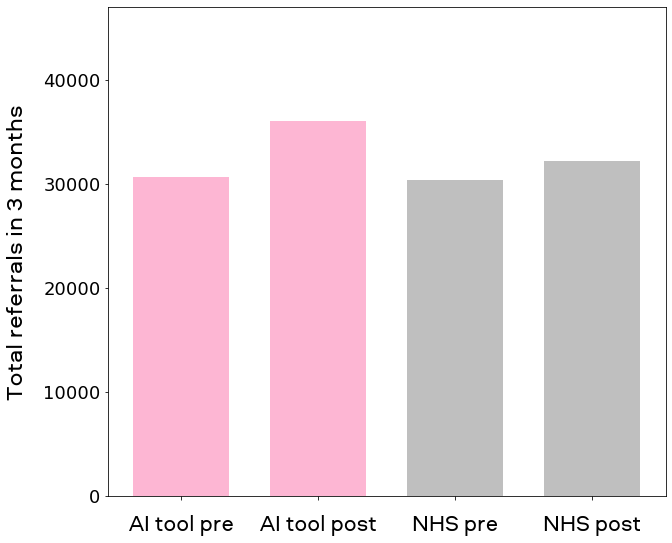

In [12]:
fig, ax = plt.subplots(figsize=(10, 9))

plt.bar([0,1], [pre_tool, post_tool], color = '#fdb6d3', width=0.7)
plt.bar([2,3], [pre_nhs, post_nhs], color = '#bfbfbf',  width=0.7)


plt.xticks([0,1,2,3], ['AI tool pre', 'AI tool post', 'NHS pre', 'NHS post'], fontsize=22, font = my_font)

plt.ylabel('Total referrals in 3 months', fontsize=24, font = my_font, labelpad=15)

ax.tick_params(axis='x', which='major', pad=15)

plt.yticks(fontsize=18)

plt.ylim(0,47000)


image_format = 'png' # e.g .png, .svg, etc.
image_name = folder_figures_save+'total_referrals.png'

# fig.savefig(image_name, format=image_format, bbox_inches="tight",dpi=1200)


In [13]:
chi2_contingency([[pre_tool, post_tool],[pre_nhs,post_nhs]])

(86.30660757373778,
 1.5409281350670706e-20,
 1,
 array([[31524.33764729, 35235.66235271],
        [29590.66235271, 33074.33764729]]))

In [14]:
print( 'percentage change for the self-referral tool', round(((post_tool - pre_tool)/post_tool)*100,2) )
print('percentage change for nhs', round(((post_nhs-pre_nhs)/post_nhs)*100,2) )